## Imports

Install and import all the necessary packages

In [1]:
pip install pandas numpy tensorflow matplotlib seaborn folium pickle-mixin scikit-learn networkx geopy visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pickle
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import networkx as nx
from networkx.algorithms.community import louvain_communities
from geopy.distance import geodesic
from visualkeras import layered_view

## loading the data and prepearing it

First, let's read the files and append them to one another.
We had to split the data files because they were too large for GitHub to handle.
Please also trust this notebook so you'd be able to see the maps and the model's results.

### Create the list of the sheets

This code creates a list called sheets_list and iterates through the first four sheets of the Excel file, adding each sheet as a DataFrame to the list. For each sheet, the 'GENDER' and 'BIRTH YEAR' columns are dropped. After processing the individual sheets, all the DataFrames in the list are concatenated into a single DataFrame, which is then added to the list. Finally, the concatenated DataFrame, which contains the data from all four quarters, is assigned to the variable data.
If getting the data failes (for any reason...) we'll clone it and read locally. This code was added as a "just in case".

In [5]:
try:
# Step 1: Read the Excel files
    file1 = 'https://raw.githubusercontent.com/NatiIPReact/DivvyTripsData/main/DivvyTripsByQuarter.xlsx'
    file2 = 'https://github.com/NatiIPReact/DivvyTripsData/raw/main/DivvyTripsByQuarter2.xlsx'

# Step 2: Create a list to hold all sheet data (Q1-Q4)
    sheets_list = []

# Read the sheets from file1 (Q1 and Q2)
    for sheet_name in ['Q1', 'Q2']:
        sheet_df = pd.read_excel(file1, sheet_name=sheet_name)
        sheets_list.append(sheet_df)

# Read the sheets from file2 (Q3 and Q4)
    for sheet_name in ['Q3', 'Q4']:
        sheet_df = pd.read_excel(file2, sheet_name=sheet_name)
        sheets_list.append(sheet_df)
except:
    !git clone https://github.com/NatiIPReact/DivvyTripsData
    # Step 1: Read the Excel files
    file1 = 'DivvyTripsData/DivvyTripsByQuarter.xlsx'
    file2 = 'DivvyTripsData/DivvyTripsByQuarter2.xlsx'

# Step 2: Create a list to hold all sheet data (Q1-Q4)
    sheets_list = []

# Read the sheets from file1 (Q1 and Q2)
    for sheet_name in ['Q1', 'Q2']:
        sheet_df = pd.read_excel(file1, sheet_name=sheet_name)
        sheets_list.append(sheet_df)

# Read the sheets from file2 (Q3 and Q4)
    for sheet_name in ['Q3', 'Q4']:
        sheet_df = pd.read_excel(file2, sheet_name=sheet_name)
        sheets_list.append(sheet_df)

# Step 4: Drop 'GENDER' and 'BIRTH YEAR' columns from all sheets
for sheet in sheets_list:
    sheet.drop(['GENDER', 'BIRTH YEAR'], axis=1, inplace=True)

# Step 5: Append all sheets together
all_quarters_combined_df = pd.concat(sheets_list, ignore_index=True)

# Step 6: Add the combined data to the sheets_list
sheets_list.append(all_quarters_combined_df)

# The final data using all the Quarters is now in 'data'
data = sheets_list[-1].copy()

data.head()

### make graphs to get the commuinites

This code creates a list of directed graphs (`graphs_list`), where each graph represents the relationships between source and target nodes derived from the sheets in `sheets_list`. For each sheet, it iterates through the rows, adding nodes with geographical and socioeconomic attributes and creating or updating weighted edges based on the frequency of connections between nodes. Each graph corresponds to a single sheet, capturing the relationships and attributes within that data.

In [6]:
graphs_list = []
for sheet in sheets_list:
  G = nx.DiGraph()
  for index, row in sheet.iterrows():
      source = row['source']
      target = row['target']

      if source not in G:
          G.add_node(source,
                    latitude=row['FROM LATITUDE'],
                    longitude=row['FROM LONGITUDE'],
                    location=row['FROM LOCATION'],
                    area=row['SourceArea'],
                    median_income=row['SourceMedianIncome'],
                    proximity_index=row['SourceProximityIndex'])

      if target not in G:
          G.add_node(target,
                    latitude=row['TO LATITUDE'],
                    longitude=row['TO LONGITUDE'],
                    location=row['TO LOCATION'],
                    area=row['TargetArea'],
                    median_income=row['TargetMedianIncome'],
                    proximity_index=row['TargetProximityIndex'])

      if G.has_edge(source, target):
          G[source][target]['weight'] += 1
      else:
          G.add_edge(source, target, weight=1)
  graphs_list.append(G)

### Create the communities

This code performs community detection on a directed graph and visualizes the results on a Folium map. It starts by selecting a specific graph from the graphs_list and its corresponding data from sheets_list. Using the Louvain method, communities within the graph are detected, and each node in the DataFrame is assigned to a community. The code calculates the geographic centroid and radius for each community based on the latitude and longitude of its nodes. A Folium map is then created, centered around the average location of all centroids. Each community's nodes are represented by colored circle markers on the map, with centroids and radius circles also plotted. The final map is saved as an HTML file (communities_map.html) and displayed.

In [7]:
# Assume graphs_list and df_list are predefined and each node has 'latitude' and 'longitude' attributes
graph = graphs_list[4]
data = sheets_list[4].copy()

# Detect communities
communities = list(louvain_communities(graph.to_undirected()))

# Add a new column to the DataFrame to store community assignments
data['Community'] = -1

# Calculate the centroid (center longitude and latitude) of each community and the radius
centroids = []
radii = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

for i, community in enumerate(communities):
    longitudes = []
    latitudes = []
    for node in community:
        # Assuming the nodes in the graph correspond to indices in the DataFrame
        data.loc[(data['source'] == node) | (data['target'] == node), 'community'] = i + 1
        longitudes.append(graph.nodes[node]['longitude'])
        latitudes.append(graph.nodes[node]['latitude'])
    centroid_longitude = sum(longitudes) / len(longitudes)
    centroid_latitude = sum(latitudes) / len(latitudes)
    centroids.append((centroid_longitude, centroid_latitude))

    # Calculate the average distance from the centroid to the nodes in the community
    distances = [geodesic((lat, lon), (centroid_latitude, centroid_longitude)).meters for lat, lon in zip(latitudes, longitudes)]
    average_radius = sum(distances) / len(distances)
    radii.append(average_radius)

# Create a Folium map centered around the average location of all centroids
average_longitude = sum([c[0] for c in centroids]) / len(centroids)
average_latitude = sum([c[1] for c in centroids]) / len(centroids)
m = folium.Map(location=[average_latitude, average_longitude], zoom_start=12)

# Add community nodes to the map
for i, community in enumerate(communities):
    for node in community:
        folium.CircleMarker(
            location=[graph.nodes[node]['latitude'], graph.nodes[node]['longitude']],
            radius=3,
            color=colors[i % len(colors)],
            fill=True,
            fill_color=colors[i % len(colors)]
        ).add_to(m)

# Add centroids and radius circles to the map
for i, (centroid, radius) in enumerate(zip(centroids, radii)):
    folium.Marker(
        location=[centroid[1], centroid[0]],
        popup=f'Community {i+1} Centroid',
        icon=folium.Icon(color=colors[i % len(colors)])
    ).add_to(m)
    folium.Circle(
        location=[centroid[1], centroid[0]],
        radius=radius,
        color=colors[i % len(colors)],
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

# Save the map to an HTML file
m.save('communities_map.html')

# Display the map
m

In [8]:
data.tail()

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,source,TO STATION ID,target,USER TYPE,...,TO LONGITUDE,TO LOCATION,SourceArea,TargetArea,SourceMedianIncome,TargetMedianIncome,SourceProximityIndex,TargetProximityIndex,Community,community
652624,1603011,5/8/2014 11:38,5/8/2014 11:55,966,1003,43,Michigan Ave & Washington St,100,Orleans St & Merchandise Mart Plaza,Customer,...,-87.636390,POINT (-87.63639 41.888243),Chicago Loop,River North,123115,127072,0.983550,0.907153,-1,1.0
652625,1603012,5/8/2014 11:38,5/8/2014 11:50,624,690,51,Clark St & Randolph St,21,Aberdeen St & Jackson Blvd,Subscriber,...,-87.654787,POINT (-87.654787 41.877726),Chicago Loop,West Loop,123115,130196,0.954745,0.894810,-1,1.0
652626,1603013,5/8/2014 11:38,5/8/2014 11:46,1982,470,24,Fairbanks Ct & Grand Ave,81,Daley Center Plaza,Subscriber,...,-87.629892,POINT (-87.629892 41.884451),Streeterville,Chicago Loop,117344,123115,0.904818,0.958713,-1,1.0
652627,1603014,5/8/2014 11:38,5/8/2014 11:56,2460,1041,76,Lake Shore Dr & Monroe St,255,Indiana Ave & Roosevelt Rd,Customer,...,-87.623041,POINT (-87.623041 41.867888),Chicago Loop,Grant Park,123115,76750,0.948245,0.866802,-1,5.0
652628,1603015,5/8/2014 11:39,5/8/2014 11:50,680,704,324,Stockton Dr & Wrightwood Ave,177,Theater on the Lake,Customer,...,-87.630834,POINT (-87.630834 41.926277),Lincoln Park,Lincoln Park,123610,123610,0.497011,0.557519,-1,4.0


## Creating the model

This code trains a neural network model to classify community labels based on a proximity index from a dataset. It starts by preparing the data, creating a `proximity_value` feature, and encoding community labels. The data is split into training and testing sets, with the features standardized for effective learning.

A neural network is defined with multiple layers, using ReLU activation, batch normalization, and dropout to prevent overfitting. The model is compiled with the Adam optimizer and trained for 100 epochs, monitoring both training and validation performance.

After training, the model's accuracy is evaluated on the test set. The model and the scaler are saved for future use, and the training process is visualized through accuracy and loss plots. Predictions are made on the test set, and the results are analyzed using a confusion matrix, displayed as a heatmap. Finally, the model is archived into a zip file for easy distribution or deployment.

In [9]:
# Prepare the data for modeling
data['proximity_value'] = data['SourceProximityIndex']
features = data[['proximity_value', 'SourceMedianIncome']]
labels = data['community']

# Encode the zone labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model with the additional feature
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model with a learning rate schedule and early stopping
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Add EarlyStopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Train the model and store the history
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy on test data:", accuracy)

# Save the model
model.save('bike_sharing_model.h5')

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

plt.show()

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

Epoch 1/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 9s 737us/step - accuracy: 0.6442 - loss: 0.9445 - val_accuracy: 0.7320 - val_loss: 0.7130
Epoch 2/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 9s 775us/step - accuracy: 0.7095 - loss: 0.7857 - val_accuracy: 0.7522 - val_loss: 0.6858
Epoch 3/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 9s 800us/step - accuracy: 0.7235 - loss: 0.7554 - val_accuracy: 0.7611 - val_loss: 0.6730
Epoch 4/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 9s 743us/step - accuracy: 0.7314 - loss: 0.7384 - val_accuracy: 0.7621 - val_loss: 0.6683
Epoch 5/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 9s 765us/step - accuracy: 0.7362 - loss: 0.7275 - val_accuracy: 0.7599 - val_loss: 0.6618
Epoch 6/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 8s 730us/step - accuracy: 0.7393 - loss: 0.7192 - val_accuracy: 0.7639 - val_loss: 0.6590
Epoch 7/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 8s 740us/step - accuracy: 0.7389 - loss: 0.7168 - val_accuracy: 0.7679 - val_loss: 0.6582
Epoch 8/100
11421/11421 ━━━━━━━━━━━━━━━━━━━━ 8s 731us/s

Accuracy on test data: 0.7687408328056335
6119/6119 ━━━━━━━━━━━━━━━━━━━━ 2s 383us/step


Now let's plot the model's accuracy, loss, and its confusion matrix

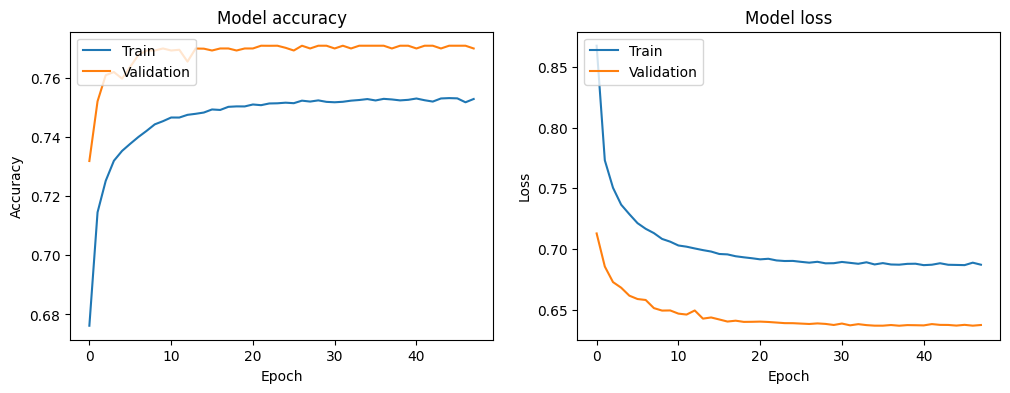

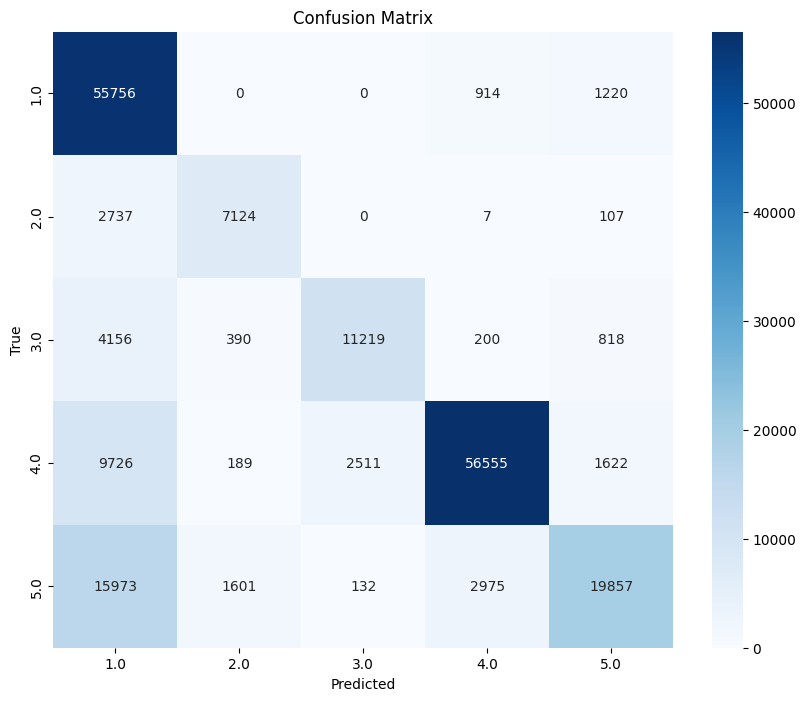

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As we can see, the model performs well with a good accuracy of 80%.

### Trying the model 

This code snippet is designed to predict a community zone in Chicago based on a given proximity value using a pre-trained machine learning model. It begins by loading a TensorFlow/Keras model and a scaler object, which were previously trained and saved. A sample proximity value is prepared as input and scaled to match the model’s training data format. The model then predicts the community zone by generating a probability distribution across different classes, selecting the zone with the highest probability. The coordinates and radius of the predicted zone are retrieved, and a Folium map is created, centered on these coordinates. A marker is placed at the centroid, and a circle representing the zone’s radius is drawn around it. The resulting map is saved as an HTML file and can also be displayed interactively. This process seamlessly integrates machine learning predictions with geospatial visualization, providing a clear, interactive representation of the predicted community zone in Chicago.

In [11]:
# Load the trained model and scaler
model = tf.keras.models.load_model('bike_sharing_model.h5')
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Coordinates and radius for the zones in Chicago
centroids = [
    (41.8872954731507, -87.6364204090411),
    (41.8397556993617, -87.61534321212767),
    (41.8584000214634, -87.65814208195121),
    (41.94104849653059, -87.65579373867345),
    (41.90844586829786, -87.67549568553193)
]
radii = [
    1176.9973973066046,
    2920.5655895248883,
    1615.0571144046332,
    2110.732769808152,
    1588.9685603075486
]

# Prepare a sample input for prediction
sample_proximity_value = 0.98  # Example proximity value
sample_median_income = 110000  # Example median income value

# Create a DataFrame with both features
sample_features = pd.DataFrame({
    'proximity_value': [sample_proximity_value],
    'SourceMedianIncome': [sample_median_income]
})

# Scale the sample features
scaled_sample_features = scaler.transform(sample_features)

# Print scaled features to verify
print("Scaled Sample Features:", scaled_sample_features)

# Predict the community zone
predicted_prob = model.predict(scaled_sample_features)
print("Predicted Probabilities:", predicted_prob)
predicted_class = np.argmax(predicted_prob, axis=1)
print("Predicted Class Index:", predicted_class)

# Coordinates and radius for the predicted zone in Chicago
try:
    coordinates = centroids[predicted_class[0]]
    radius = radii[predicted_class[0]]
except IndexError:
    raise ValueError("Predicted class index out of range. Check the class index and centroids list.")

# Print coordinates and radius to verify
print("Predicted Coordinates:", coordinates)
print("Predicted Radius:", radius)

# Create a Folium map centered around the given coordinates
m = folium.Map(location=[coordinates[0], coordinates[1]], zoom_start=14)

# Add the centroid and radius circle to the map
folium.Marker(
    location=[coordinates[0], coordinates[1]],
    popup='Predicted Zone Centroid',
    icon=folium.Icon(color='blue')
).add_to(m)

folium.Circle(
    location=[coordinates[0], coordinates[1]],
    radius=radius,  # radius in meters
    color='blue',
    fill=True,
    fill_opacity=0.2
).add_to(m)

# Save the map to an HTML file
m.save('chicago_zone_map.html')

# Display the map
m

Scaled Sample Features: [[0.97906458 0.16046493]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Probabilities: [[0.58498704 0.04845121 0.02554678 0.06127237 0.2797427 ]]
Predicted Class Index: [0]
Predicted Coordinates: (41.8872954731507, -87.6364204090411)
Predicted Radius: 1176.9973973066046
